In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTENC, SMOTEN
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss, InstanceHardnessThreshold, NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

In [2]:
train = pd.read_csv("../data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("../data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("../data/sample_submission.csv", encoding="utf-8-sig")

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

train.drop('abandoned_learning_sessions', axis=1, inplace=True)
test.drop('abandoned_learning_sessions', axis=1, inplace=True)
train.drop('average_login_time', axis=1, inplace=True)
test.drop('average_login_time', axis=1, inplace=True)
train.drop('payment_pattern', axis=1, inplace=True)
test.drop('payment_pattern', axis=1, inplace=True)

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
#numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
#categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])



# 전처리 후 학습 데이터 확인
train.head()

user_id  subscription_duration  recent_login_time  \
0  b919c29d               0.167046          -0.121165   
1  a0a60abb               0.621553           0.357181   
2  b9f171ae               1.530566          -1.675788   
3  5dc0ba8b              -1.650980           0.476767   
4  65c83654              -1.196473          -1.197443   

   average_time_per_learning_session  monthly_active_learning_days  \
0                          -0.829869                      0.786885   
1                           0.316456                      0.498363   
2                          -0.591616                      0.065581   
3                          -0.218820                      0.931145   
4                          -0.431503                      0.931145   

   total_completed_courses  recent_learning_achievement  \
0                 1.038128                    -0.669045   
1                 0.212579                     2.261009   
2                 0.487762                     1.939124   
3                 1.588495                    -0.489192   
4                -0.612970                     0.691049   

   community_engagement_level  preferred_difficulty_level  subscription_type  \
0                    0.090246                           1                  0   
1                   -0.702077                           2                  0   
2                    0.090246                           2                  1   
3                   -0.702077                           1                  0   
4                    0.090246                           2                  0   

   customer_inquiry_history  target  
0                  1.400157       0  
1                 -0.711163       1  
2                 -1.414937       1  
3                 -0.711163       1  
4                  0.696384       1

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])



# 전처리 후 학습 데이터 확인
train.head()

user_id  subscription_duration  recent_login_time  average_login_time  \
0  b919c29d               0.167046          -0.121165           -0.015962   
1  a0a60abb               0.621553           0.357181            1.152389   
2  b9f171ae               1.530566          -1.675788            0.400155   
3  5dc0ba8b              -1.650980           0.476767            0.877690   
4  65c83654              -1.196473          -1.197443            2.130972   

   average_time_per_learning_session  monthly_active_learning_days  \
0                          -0.829869                      0.786885   
1                           0.316456                      0.498363   
2                          -0.591616                      0.065581   
3                          -0.218820                      0.931145   
4                          -0.431503                      0.931145   

   total_completed_courses  recent_learning_achievement  \
0                 1.038128                    -0.669045   
1                 0.212579                     2.261009   
2                 0.487762                     1.939124   
3                 1.588495                    -0.489192   
4                -0.612970                     0.691049   

   abandoned_learning_sessions  community_engagement_level  \
0                    -0.024844                    0.090246   
1                    -0.594656                   -0.702077   
2                    -0.024844                    0.090246   
3                    -1.734280                   -0.702077   
4                    -0.594656                    0.090246   

   preferred_difficulty_level  subscription_type  customer_inquiry_history  \
0                           1                  0                  1.400157   
1                           2                  0                 -0.711163   
2                           2                  1                 -1.414937   
3                           1                  0                 -0.711163   
4                           2                  0                  0.696384   

   payment_pattern  target  
0                5       0  
1                6       1  
2                7       1  
3                0       1  
4                0       1

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
counts = list(y_train.value_counts())

from sklearn.utils.class_weight import compute_class_weight 

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}
print(weights)

# 로지스틱 회귀 모델 초기화 및 학습
cat_model = CatBoostClassifier(random_state=42, class_weights=weights)
param_grid = {  'iterations': [100, 300, 500, 700],
                'depth': [4, 6, 8],
                'learning_rate': [0.1, 0.01, 0.001],
              'random_state' : [42]
             }
f1_scorer = make_scorer(f1_score, average='macro')
cat_grid = GridSearchCV(cat_model, param_grid, scoring=f1_scorer, verbose=2)
cat_grid.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = cat_grid.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
print(f'best accuracy : {cat_grid.best_score_}')
print('best param : ', cat_grid.best_params_)

print("검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_val, val_predictions, zero_division=0))
## 데이터 3개 뺀거

{0: 1.3144922773578704, 1: 0.8069396812588259}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 0.6903971	total: 148ms	remaining: 14.7s
1:	learn: 0.6878026	total: 150ms	remaining: 7.35s
2:	learn: 0.6857721	total: 152ms	remaining: 4.91s
3:	learn: 0.6837163	total: 154ms	remaining: 3.68s
4:	learn: 0.6820266	total: 155ms	remaining: 2.95s
5:	learn: 0.6806002	total: 157ms	remaining: 2.46s
6:	learn: 0.6794310	total: 159ms	remaining: 2.11s
7:	learn: 0.6783472	total: 160ms	remaining: 1.84s
8:	learn: 0.6774984	total: 162ms	remaining: 1.64s
9:	learn: 0.6764167	total: 163ms	remaining: 1.47s
10:	learn: 0.6754736	total: 165ms	remaining: 1.33s
11:	learn: 0.6747496	total: 167ms	remaining: 1.22s
12:	learn: 0.6741016	total: 168ms	remaining: 1.12s
13:	learn: 0.6733650	total: 169ms	remaining: 1.04s
14:	learn: 0.6730414	total: 171ms	remaining: 969ms
15:	learn: 0.6724799	total: 173ms	remaining: 906ms
16:	learn: 0.6720560	total: 174ms	remaining: 850ms
17:	learn: 0.6716390	total: 175ms	

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
counts = list(y_train.value_counts())

from sklearn.utils.class_weight import compute_class_weight 

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}
print(weights)

# 로지스틱 회귀 모델 초기화 및 학습
cat_model = CatBoostClassifier(random_state=42, class_weights=weights, verbose=0)
param_grid = {  'iterations': [100, 300, 500, 700],
                'depth': [4, 6, 8],
                'learning_rate': [0.1, 0.01, 0.001],
              'random_state' : [42]
             }
f1_scorer = make_scorer(f1_score, average='macro')
cat_grid = GridSearchCV(cat_model, param_grid, scoring=f1_scorer, verbose=2)
cat_grid.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = cat_grid.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
print(f'best accuracy : {cat_grid.best_score_}')
print('best param : ', cat_grid.best_params_)

print("검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_val, val_predictions, zero_division=0))
# 데이터 전부 포함

{0: 1.3144922773578704, 1: 0.8069396812588259}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.4s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.2s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# 훈련 데이터를 기반으로 클래스 가중치 계산
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}
print(weights)

# 최적의 하이퍼파라미터로 모델 초기화
best_params = cat_grid.best_params_
best_cat_model = CatBoostClassifier(**best_params, class_weights=weights)

# 클래스 가중치를 적용하여 모델 학습
best_cat_model.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = best_cat_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

print("검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_val, val_predictions, zero_division=0))

{0: 1.3144922773578704, 1: 0.8069396812588259}
0:	learn: 0.6868246	total: 10.1ms	remaining: 7.09s
1:	learn: 0.6811451	total: 21ms	remaining: 7.34s
2:	learn: 0.6764586	total: 33.7ms	remaining: 7.83s
3:	learn: 0.6729467	total: 39.7ms	remaining: 6.91s
4:	learn: 0.6696023	total: 49.6ms	remaining: 6.89s
5:	learn: 0.6673905	total: 60.1ms	remaining: 6.95s
6:	learn: 0.6651767	total: 68.7ms	remaining: 6.8s
7:	learn: 0.6625455	total: 80ms	remaining: 6.92s
8:	learn: 0.6606574	total: 89.5ms	remaining: 6.87s
9:	learn: 0.6584957	total: 99.7ms	remaining: 6.88s
10:	learn: 0.6561934	total: 106ms	remaining: 6.65s
11:	learn: 0.6543703	total: 111ms	remaining: 6.37s
12:	learn: 0.6523737	total: 115ms	remaining: 6.09s
13:	learn: 0.6506424	total: 121ms	remaining: 5.92s
14:	learn: 0.6485443	total: 125ms	remaining: 5.7s
15:	learn: 0.6452782	total: 130ms	remaining: 5.56s
16:	learn: 0.6426358	total: 134ms	remaining: 5.38s
17:	learn: 0.6404497	total: 139ms	remaining: 5.28s
18:	learn: 0.6379750	total: 143ms	remaini

In [ ]:
# 테스트 데이터에 대한 예측 수행
test_X = test.drop(columns=['user_id'])  # user_id는 제외하고 특성 데이터로 사용
test_predictions = cat_grid.predict(test_X)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions

import os
model = 'gb'
path = f"./{model}"
if not os.path.exists(path):
  os.mkdir(path)
# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
submit_path = f'{path}/baseline_submit({model}_tuned_model_noPreprocessing).csv'
sample.to_csv(submit_path, index=False)

sample.head()

user_id  target
0  0001d6e9       0
1  0002c77d       1
2  0002df5b       0
3  000b6068       1
4  00184a0c       1

----------

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd

# 데이터 불러오기
train = pd.read_csv("../data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("../data/test.csv", encoding="utf-8-sig")

y = train['target']

train.drop(columns=['user_id', 'target'], axis=1, inplace=True)
test.drop(columns=['user_id'], axis=1, inplace=True)

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
# 중요한 변수 설정
important_variable = 'average_time_per_learning_session'

# 수치형 데이터 및 중요한 변수 분할
train_numeric_data = train[numerical_cols]
test_numeric_data = test[numerical_cols]


# 수치형 파이프라인 구성 (스케일링 및 PCA)
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

# 변환을 적용하는 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numerical_cols)
    ]
)

#레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전체 데이터 처리
train_numeric_processed_data = preprocessor.fit_transform(train)
test_numeric_processed_data = preprocessor.transform(test)

#스케일링된 중요한 변수들을 다시 DataFrame에 추가
scaler = StandardScaler()
train[important_variable] = scaler.fit_transform(train[important_variable].values.reshape(-1, 1))
test[important_variable] = scaler.transform(test[important_variable].values.reshape(-1, 1))

categorical_cols.append(important_variable)

train = pd.concat([
    pd.DataFrame(train_numeric_processed_data, columns=['pca1', 'pca2']),  # PCA 컬럼 이름 설정 필요
    train[categorical_cols]
], axis=1)

test = pd.concat([
    pd.DataFrame(test_numeric_processed_data, columns=['pca1', 'pca2']),  # PCA 컬럼 이름 설정 필요
    test[categorical_cols]
], axis=1)

train.head()

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)
X_train, y_train = OneSidedSelection().fit_resample(X_train, y_train)
counts = list(y_train.value_counts())

from sklearn.utils.class_weight import compute_class_weight 

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}
print(weights)

# 로지스틱 회귀 모델 초기화 및 학습
cat_model = CatBoostClassifier(random_state=42, class_weights=weights, verbose=0)
param_grid = {  'iterations': [100, 300, 500, 700],
                'depth': [4, 6, 8],
                'learning_rate': [0.1, 0.01, 0.001],
              'random_state' : [42]
             }
f1_scorer = make_scorer(f1_score, average='macro')
cat_grid = GridSearchCV(cat_model, param_grid, scoring=f1_scorer, verbose=2)
cat_grid.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = cat_grid.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)
print(f'best accuracy : {cat_grid.best_score_}')
print('best param : ', cat_grid.best_params_)

print("검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_val, val_predictions, zero_division=0))

{0: 1.1411436082813013, 1: 0.8899282419272168}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.1, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0.3s
[CV] END depth=4, iterations=100, learning_rate=0.01, random_state=42; total time=   0

In [7]:
#test.drop(columns=['user_id'], inplace=True, axis=1) 
sample = pd.read_csv("../data/sample_submission.csv", encoding="utf-8-sig")
test_predictions = cat_grid.predict(test)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions

#리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
submit_path = './cat_pca_onesideselection).csv'
sample.to_csv(submit_path, index=False)

sample.head()

user_id  target
0  0001d6e9       0
1  0002c77d       1
2  0002df5b       0
3  000b6068       1
4  00184a0c       1

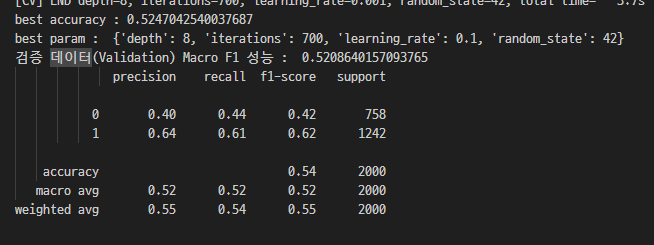